In [3]:
# Cell 1: Imports
import os
import glob
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# Cell 2: Load the Datasets and Fix Test Column Order
train_files = glob.glob(os.path.join("Data", "Train", "*.csv"))
test_files = glob.glob(os.path.join("Data", "Test", "*.csv"))

if len(train_files) == 0:
    raise FileNotFoundError("No training CSV files found in Data/Train")
if len(test_files) == 0:
    raise FileNotFoundError("No testing CSV files found in Data/Test")

# Read training files (using default CSV settings)
train_dfs = []
for file in train_files:
    try:
        df = pd.read_csv(file, engine='python')
        train_dfs.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")
train_df = pd.concat(train_dfs, ignore_index=True)

# Read testing files
test_dfs = []
for file in test_files:
    try:
        df = pd.read_csv(file, engine='python')
        test_dfs.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")
test_df = pd.concat(test_dfs, ignore_index=True)

# Fix test_df column order if necessary.
if test_df.columns[0].strip().lower() == "label":
    test_df = test_df[["Statement", "Label"]]

print("Training dataset shape:", train_df.shape)
print("Testing dataset shape:", test_df.shape)

Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_000.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_001.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_002.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_003.csv: ',' expected after '"'
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_005.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_006.csv: ',' expected after '"'
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_007.csv: Expected 2 fields in line 330, saw 3
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_010.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_012.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_013.csv: ',' expected after '"'
Error reading Data/Train/f

In [5]:
# Cell 3: Handle Missing Values Precisely
# Drop rows where the 'Statement' column is empty after stripping whitespace.
train_df = train_df[train_df["Statement"].astype(str).str.strip() != ""]
test_df = test_df[test_df["Statement"].astype(str).str.strip() != ""]

print("Processed Training dataset shape:", train_df.shape)
print("Processed Testing dataset shape:", test_df.shape)

Processed Training dataset shape: (28633, 2)
Processed Testing dataset shape: (7011, 2)


In [6]:
# Cell 4: Extract Features and Labels
X_train = train_df["Statement"]
y_train = train_df["Label"]

X_test = test_df["Statement"]
y_test = test_df["Label"]

# (Optional) Verify with an example:
print("Example training statement:", X_train.iloc[0])

Example training statement: Sainsburyâ€™s sales have dropped further after it was forced to cut prices amid heavy competition from discount rivals. Sales at stores open for more than a year fell by 1.1% in the three months to 24 September, compared with the 0.8% decline reported for the previous three months. Shares in Sainsburyâ€™s slid 3.5% to 242.2p in morning trading, as City analysts said the supermarket had slightly underperformed against expectations and appeared to be under more pressure in comparison with Morrisons and Tesco. Mike Coupe, Sainsburyâ€™s chief executive, said the fall in sales was driven by price cuts. Although a 1% dip in prices resulted in a drop in the total value of Sainsburyâ€™s sales in the quarter, the reductions drew more people to Sainsburyâ€™s tills and meant the group sold a higher volume of goods. Coupe said there had been no discernible impact on customer behaviour after the EU referendum, and he thought there would not be any impact on shopping unle

In [7]:
# Cell 4: Clean and Shuffle the Data
# Keep only binary labels (0 or 1)
train_df = train_df[train_df['Label'].isin([0, 1])]
test_df = test_df[test_df['Label'].isin([0, 1])]

# Convert the Label columns to integers.
train_df['Label'] = train_df['Label'].astype(int)
test_df['Label'] = test_df['Label'].astype(int)

# Shuffle the data.
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Re-extract features and labels after cleaning.
X_train = train_df['Statement']
y_train = train_df['Label']
X_test = test_df['Statement']
y_test = test_df['Label']

# Display class distribution
print("\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Percentage of fake news (0): {y_train.value_counts()[0]/len(y_train)*100:.2f}%")
print(f"Percentage of true news (1): {y_train.value_counts()[1]/len(y_train)*100:.2f}%")

print("\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Percentage of fake news (0): {y_test.value_counts()[0]/len(y_test)*100:.2f}%")
print(f"Percentage of true news (1): {y_test.value_counts()[1]/len(y_test)*100:.2f}%")


Class distribution in training set:
Label
1    11924
0    11219
Name: count, dtype: int64
Percentage of fake news (0): 48.48%
Percentage of true news (1): 51.52%

Class distribution in test set:
Label
1    4769
0    2242
Name: count, dtype: int64
Percentage of fake news (0): 31.98%
Percentage of true news (1): 68.02%


In [8]:
# Cell 5: Text Preprocessing and Tokenization
def tokenize(text):
    # Convert text to lowercase and extract word tokens.
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Build vocabulary from the training statements.
all_tokens = []
for text in X_train:
    all_tokens.extend(tokenize(text))
    
# Limit vocabulary to the 15,000 most common words.
max_vocab = 15000
freq = Counter(all_tokens)
vocab = {word: i+2 for i, (word, count) in enumerate(freq.most_common(max_vocab))}
vocab_size = len(vocab) + 2  # Reserve 0 for padding, 1 for unknown.

print(f"Vocabulary size: {vocab_size}")

def text_to_sequence(text, vocab):
    tokens = tokenize(text)
    return [vocab.get(token, 1) for token in tokens]

# Convert texts to sequences of token indices.
X_train_seq = [text_to_sequence(text, vocab) for text in X_train]
X_test_seq = [text_to_sequence(text, vocab) for text in X_test]

# Get sequence lengths for packing
X_train_lengths = [len(seq) for seq in X_train_seq]
X_test_lengths = [len(seq) for seq in X_test_seq]

# Set fixed maximum sequence length.
max_len = 300

def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))
    else:
        return seq[:max_len]

# Apply padding/truncation.
X_train_pad = [pad_sequence(seq, max_len) for seq in X_train_seq]
X_test_pad = [pad_sequence(seq, max_len) for seq in X_test_seq]

# Update sequence lengths after truncation
X_train_lengths = [min(len(seq), max_len) for seq in X_train_seq]
X_test_lengths = [min(len(seq), max_len) for seq in X_test_seq]

Vocabulary size: 15002


In [9]:
# Cell 6: Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
X_train_lengths = torch.tensor(X_train_lengths, dtype=torch.long)
X_test_lengths = torch.tensor(X_test_lengths, dtype=torch.long)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print(f"Training data shape: {X_train_tensor.shape}")
print(f"Testing data shape: {X_test_tensor.shape}")

Training data shape: torch.Size([23143, 300])
Testing data shape: torch.Size([7011, 300])


In [10]:
# Cell 7: Create Dataset and DataLoader with Augmentation
class NewsDataset(Dataset):
    def __init__(self, texts, lengths, labels, augment=False, drop_prob=0.1):
        self.texts = texts
        self.lengths = lengths
        self.labels = labels
        self.augment = augment
        self.drop_prob = drop_prob
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        length = self.lengths[idx]
        label = self.labels[idx]
        
        if self.augment:
            # Apply word dropout - replace random non-padding tokens with <unk> (index 1)
            text_list = text.tolist()
            text_list = [token if token == 0 or np.random.rand() > self.drop_prob else 1 for token in text_list]
            text = torch.tensor(text_list, dtype=torch.long)
            
        return text, length, label

# Create train/val split
train_size = int(0.8 * len(X_train_tensor))
val_size = len(X_train_tensor) - train_size

train_dataset = NewsDataset(X_train_tensor[:train_size], X_train_lengths[:train_size], 
                           y_train_tensor[:train_size], augment=True)
val_dataset = NewsDataset(X_train_tensor[train_size:], X_train_lengths[train_size:], 
                         y_train_tensor[train_size:], augment=False)
test_dataset = NewsDataset(X_test_tensor, X_test_lengths, y_test_tensor, augment=False)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

Train set: 18514 samples
Validation set: 4629 samples
Test set: 7011 samples


In [11]:
# Cell 8: Define RNN Model with Support for Packed Sequences
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                         bidirectional=True, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        # text shape: [batch_size, seq_len]
        embedded = self.embedding(text)
        
        # Pack padded batch of sequences for RNN
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        
        # Use the final hidden state from each direction
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        hidden = F.relu(self.fc(hidden))
        return self.classifier(self.dropout(hidden))

# Initialize the model
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
OUTPUT_DIM = 2
NUM_LAYERS = 2
DROPOUT = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNClassifier(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT)
model = model.to(device)

print(model)

RNNClassifier(
  (embedding): Embedding(15002, 300, padding_idx=0)
  (rnn): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)


In [12]:
# Cell 9: Training Loop with Validation and Early Stopping
N_EPOCHS = 10
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# For tracking metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 3
patience_counter = 0
best_model_state = None

for epoch in range(N_EPOCHS):
    # Training phase
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for batch in train_loader:
        text, text_lengths, labels = batch
        text = text.to(device)
        text_lengths = text_lengths.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths)
        loss = criterion(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(predictions, 1)
        correct = (predicted == labels).float().sum()
        
        epoch_loss += loss.item() * text.size(0)
        epoch_acc += correct.item()
    
    # Calculate average metrics
    epoch_loss /= len(train_dataset)
    epoch_acc /= len(train_dataset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_acc = 0
    
    with torch.no_grad():
        for batch in val_loader:
            text, text_lengths, labels = batch
            text = text.to(device)
            text_lengths = text_lengths.to(device)
            labels = labels.to(device)
            
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            
            _, predicted = torch.max(predictions, 1)
            correct = (predicted == labels).float().sum()
            
            val_loss += loss.item() * text.size(0)
            val_acc += correct.item()
    
    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# Load the best model state
if best_model_state:
    model.load_state_dict(best_model_state)

Epoch 1/10
Train Loss: 0.3961 | Train Acc: 80.05%
Val Loss: 0.1248 | Val Acc: 95.38%
Epoch 2/10
Train Loss: 0.1119 | Train Acc: 95.84%
Val Loss: 0.0932 | Val Acc: 96.52%
Epoch 3/10
Train Loss: 0.0601 | Train Acc: 97.81%
Val Loss: 0.0955 | Val Acc: 96.78%
Epoch 4/10
Train Loss: 0.0320 | Train Acc: 98.87%
Val Loss: 0.1431 | Val Acc: 95.94%
Epoch 5/10
Train Loss: 0.0240 | Train Acc: 99.21%
Val Loss: 0.1555 | Val Acc: 95.44%
Early stopping triggered after 5 epochs


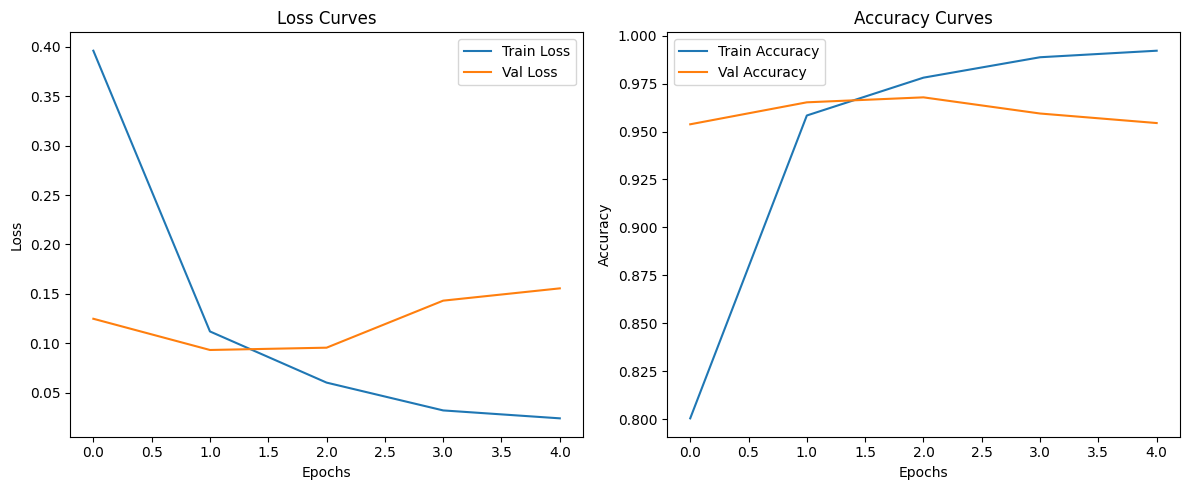

In [13]:
# Cell 10: Plot Training Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

RNN Model Test Performance:
Accuracy: 0.9101
Precision: 0.9174
Recall: 0.9101
F1 Score: 0.9062


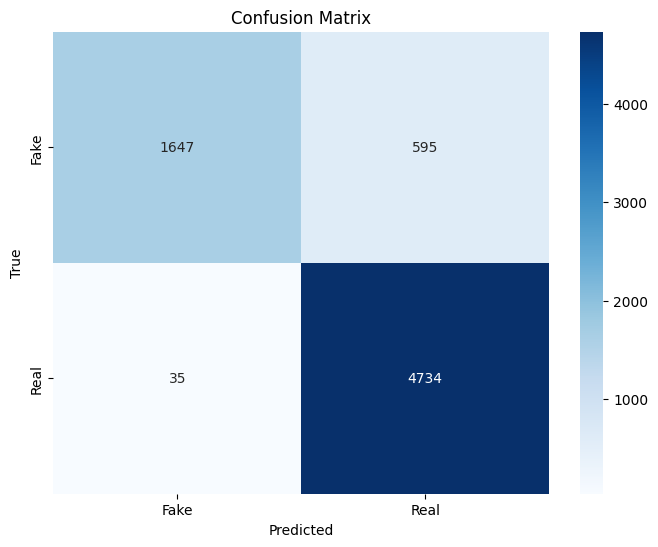


Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      0.73      0.84      2242
        Real       0.89      0.99      0.94      4769

    accuracy                           0.91      7011
   macro avg       0.93      0.86      0.89      7011
weighted avg       0.92      0.91      0.91      7011



In [14]:
# Cell 11: Evaluate on Test Set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch in test_loader:
        text, text_lengths, labels = batch
        text = text.to(device)
        text_lengths = text_lengths.to(device)
        
        predictions = model(text, text_lengths)
        _, predicted = torch.max(predictions, 1)
        
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.numpy())

# Calculate metrics
test_acc = accuracy_score(y_true, y_pred)
test_prec = precision_score(y_true, y_pred, average='weighted')
test_rec = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

print("RNN Model Test Performance:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall: {test_rec:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))